## Import original data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seanborn as sns

In [2]:
WF_train = pd.read_csv("Weather Forecast Training.csv")
WF_test = pd.read_csv("Weather Forecast Testing.csv")

# Potential data quality issues

   For cluster algorithm like K-means, It takes numerical data as input. The data type of columns like Location, WindGustDir and WindDir is categorical and should be transformed.
   
   Missing values exist in both test set and train set, for example, there are some NaNs in Evaporation and Sunshine columns in train set, which can have a significant effect on the conclusions drawn from data.
   
   In some attributes, a single data points might have a extremly high or lower value or have no contribution to the whole tendency of data, which reflect noisy data and outliers. Noise refers to the irrelevant information or randomness in a dataset, outliers refers to data points that is much different than other values. Removal of noisy data and outlier is required for clustering and decision tree, otherwise, it will leads to overfitting.
   
   Datas are not in the same scale. Apparently, different attribute has different units. For instance, MinTemp and MaxTemp have degrees as their units, while humidty has percent. Distanced-based cluster algorithms need a rescale to prevents variables with larger scales from dominating how clusters are defined. The same scale of attributes means they are equally important to cluster algorithm.
   
   In this data set, not every attribute contributes to the result of if it will rain tomorrow, which refers to irrelevant attributes. Irrelevant attributes have a huge impact at the accuracy of result of cluster.

# Section 1:Data Preparation

## Basic data cleaning

In this part, we are going to cope with missing values and duplicates. Noticed that there are more than 20,000 rows containing miss values which is a large portion of original data set with 50,000 more rows, filling in missing values might have large amount of misleading information. So we directly drop rows with missing values. The rest set containing more than 20,000 rows is still representative.

In [3]:
#test na
WF_train.isna()
WF_test.isna()
#drop rows with na and duplicates
WF_train.dropna(inplace = True)
WF_test.dropna(inplace = True)
WF_test.drop_duplicates(inplace = True)
WF_train.drop_duplicates(inplace = True)
WF_test.reset_index(drop = True, inplace = True)
WF_train.reset_index(drop = True, inplace = True)

# Exploratory Data Analysis

## Relationship between Temp and MaxTemp

We find that temp and maxtemp has a strong linear relationship.

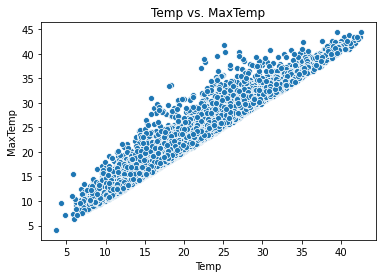

In [71]:
ax = sns.scatterplot(WF_train.Temp, WF_train.MaxTemp)
plt.title('Temp vs. MaxTemp')
plt.show()

## portion of rain and not rain tomorrow

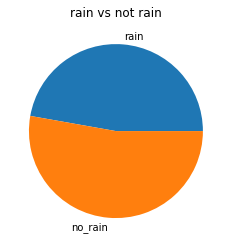

In [77]:
rain_tomorrow = WF_train[WF_train['RainTomorrow'] == 'Yes'].count()[0]
no_rain_tomorrow = WF_train[WF_train['RainTomorrow'] == 'No'].count()[0]
plt.figure()
plt.pie([rain_tomorrow,no_rain_tomorrow],  labels = ['rain', 'no_rain'])
plt.title('rain vs not rain')
plt.show()

## Data Transformation

Seen that in original data set, there is a combination of numerical and categorical data, while as input of distance-based cluster algorithms, the data type should be numerical. Decision tree classifier in sklearn is not able to handle with a mix of numeric and categorical data. So, here we conduct a label encoder to transform categorical columns to numerical.

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Location = WF_train['Location'].unique().tolist()
WindGustDir = WF_train['WindGustDir'].unique().tolist()
WindDir = WF_train['WindDir'].unique().tolist()
#transform column Location
le.fit(Location)
WF_train['Location'] = le.transform(WF_train['Location'])
WF_test['Location'] = le.transform(WF_test['Location'])
#transform column WindGustDir
le.fit(WindGustDir)
WF_train['WindGustDir'] = le.transform(WF_train['WindGustDir'])
WF_test['WindGustDir'] = le.transform(WF_test['WindGustDir'])
#transform column WindDir
le.fit(WindDir)
WF_train['WindDir'] = le.transform(WF_train['WindDir'])
WF_test['WindDir'] = le.transform(WF_test['WindDir'])
#transform column RainToday
Rain_map = {'Yes' : 1, 'No' : 0}
WF_train['RainToday'].replace(Rain_map, inplace = True)
WF_test['RainToday'].replace(Rain_map, inplace = True)
#store data for decision tree classifier
DT_df_train = WF_train.copy()
DT_df_test = WF_test.copy()

## Removal of noise and outliers

Z-score method is used to detect outliers, which tells how many standard deviations away a data point from the mean. If the z score of a data point is more thant 3, it indicates that the data point is quite different from the others which might lead to overfitting.

In [5]:
#define numeric columns except the columns after transformation
numeric_col = WF_train.columns.tolist()
numeric_col.remove('RainTomorrow')
numeric_col.remove('Location')
numeric_col.remove('WindGustDir')
numeric_col.remove('WindDir')
#outlier detection
outlier_index = []
for col in numeric_col:
    if_outlier = np.abs(WF_train.loc[:,col] - WF_train.loc[:,col].mean())/WF_train.loc[:,col].std()>3
    outlier_col_index = WF_train[if_outlier].index
    outlier_index = outlier_index + outlier_col_index.tolist()
WF_train.drop(index = np.unique(outlier_index), inplace = True)
WF_train.reset_index(inplace = True, drop = True)

## Dimension reduction

In this section we are going to remove strongly correlated attributes. As the heatmap shows, Temp and MaxTemp have a extremly strong linear relationship defined as correlation between 2 columns has coefficient greater than 0.9. Especially for distance-based cluster algorithms. Collinearity can becom a major problem cause attributes with strong linear relationship will multify the effect when calculating centroid. For further usage to K-means and HAC, we need to remove strongly corelated attributes

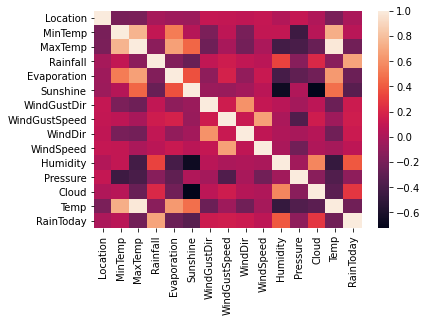

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
corrMatrix = WF_train.corr()
sns.heatmap(corrMatrix)
plt.show()
corrMatrix[corrMatrix > .90]
WF_train_re = WF_train.drop('Temp', axis = 1)

## Data normalizition

In [7]:
from  sklearn.preprocessing import MinMaxScaler
mmc = MinMaxScaler()
WF_train_re.drop('RainTomorrow', inplace = True, axis = 1)
WF_train_mmc = mmc.fit_transform(WF_train_re)
df_normalized = pd.DataFrame(WF_train_mmc, columns = WF_train_re.columns, index = WF_train_re.index)

# Section 2: Data Model

## Clustering Algorithm1: K-means

For algorithms like clustering for classification, numbers of clusters is the most important hyperparameter. To get the best performance of the model, elbow method is often used to decide optimal number of clusters, which consists of plotting the explained varation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. That is how we repurposed clustering algorithm. In this case, the class of classification is fixed, we can not tune the hyper parameter numbers of clusters.

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2, n_init = 25, max_iter = 100, random_state = 6)
kmeans_output = kmeans.fit(df_normalized)
Kmeans_pred = kmeans_output.labels_
pred_df = pd.DataFrame({'RainTomorrow':WF_train['RainTomorrow'], 'RainTomorrow_pre':Kmeans_pred})
FP,TP = pred_df[pred_df['RainTomorrow'] == 'Yes']['RainTomorrow_pre'].value_counts()
TN,FN = pred_df[pred_df['RainTomorrow'] == 'No']['RainTomorrow_pre'].value_counts()
accuracy = (TP + TN)/pred_df['RainTomorrow'].count()
print("The classification accuracy of K-means:",accuracy)

The classification accuracy of K-means: 0.6602956547707929


## Clustering Algorithm2: HAC

To decide the best numbers of clusters we draw a dendrogram. As it shows, the best numbers of clusters is 2 which equals to the fixed number in this case. Thus, we have almost all the hyperparameter fixed. In cluster algorithm for classification. Accuracy is used to mearsure the model performance

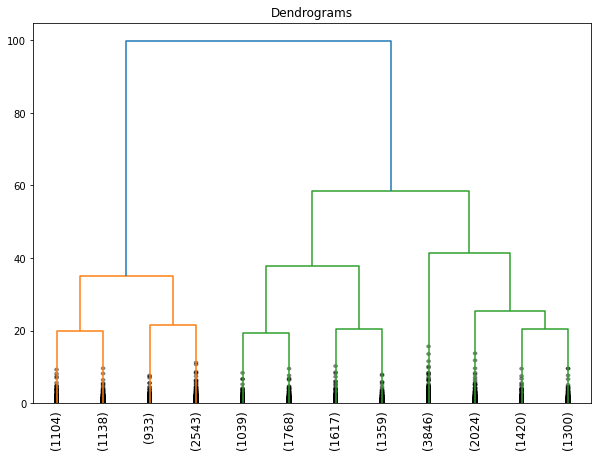

In [27]:
plt.figure(figsize = (10,7))
plt.title("Dendrograms")
dendro = sch.dendrogram(sch.linkage(df_normalized, method = 'ward'),
                        truncate_mode = 'lastp',
                       p=12,
                       leaf_rotation = 90,
                       leaf_font_size = 12,
                       show_contracted = True)
plt.show()

In [9]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
HAC = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean',
                             linkage = 'ward')
HAC_output = HAC.fit(df_normalized)
HAC_pred = HAC_output.labels_
predHAC_df = pd.DataFrame({'RainTomorrow':WF_train['RainTomorrow'], 'RainTomorrow_pre_hac':HAC_output.labels_})
FP_hac,TP_hac = predHAC_df[predHAC_df['RainTomorrow'] == 'Yes']['RainTomorrow_pre_hac'].value_counts()
TN_hac,FN_hac = predHAC_df[predHAC_df['RainTomorrow'] == 'No']['RainTomorrow_pre_hac'].value_counts()
accuracy_HAC = (TP_hac + TN_hac)/predHAC_df['RainTomorrow'].count()
accuracy_HAC

0.6602956547707929

## Decision Tree

Decision tree algorithm recursively partitioning the input space in training step and traverse the tree with the test data point to predict. Firstly, we create a decision tree model and calculate its accuracy. And then perform a hyperparameter tuning to find the best combination of hyperparamters which makes accuracy of decision tree model reaches the greatest and also reache the balance of bias and variance, plot ROC curve and calculate AUC score which measure the model's ability to distingush between the classes. Finally, visualize the tree set via tree plot demonstrating the whole decision tree process

### Model construction and hyperparameter tuning

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
Y = DT_df_train['RainTomorrow']
X = DT_df_train.drop('RainTomorrow', axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 1)
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(f"Accuracy before hyperparameter tuning:{round(metrics.accuracy_score(Y_test,Y_pred)*100)}%")

Accuracy before hyperparameter tuning:73.0%


In [11]:
#condunct a hyperparameter tuning
param_grid = {'criterion':['gini','entropy'],
            'min_samples_split':[2,10,20],
             'max_depth':[5,10,20,25,30],
             'min_samples_leaf':[1,5,10],
             'max_leaf_nodes':[2,5,10,20]}
grid = GridSearchCV(clf, param_grid, cv = 10, scoring='accuracy')
grid.fit(X_train, Y_train)
print(f"Accuracy after hyperparameter tuning:{round(grid.best_score_*100)}%")

Accuracy after hyperparameter tuning:78.0%


After hyperparameter tuning, we can see that accuracy of the model improved, which means an appropriate selection of parameters do enhance the model ability. Here we choose the hyperparameters as following to construct the best decision tree model.

In [12]:
print("Best parameters for decision tree algorithm are:")
for hps,values in grid.best_params_.items():
    print(f"{hps}:{values}")

Best parameters for decision tree algorithm are:
criterion:gini
max_depth:5
max_leaf_nodes:20
min_samples_leaf:1
min_samples_split:2


In [13]:
#construct best decision tree model with hyperparameters.
clf_best = DecisionTreeClassifier(criterion='gini',
                                 max_depth=5,
                                 max_leaf_nodes=20,
                                 min_samples_leaf=1,
                                 min_samples_split=2)
clf_best.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=20)

### ROC curve and AUC score

AUC score: 0.8576308627190348


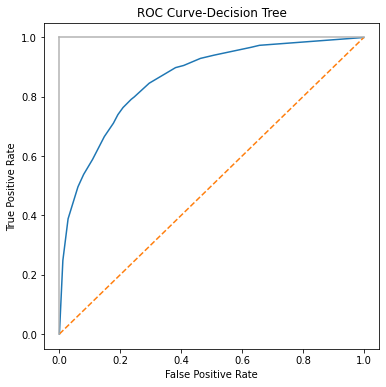

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score1 = grid.predict_proba(X_test)[:,1]
FP_rate, TP_rate, threshold = roc_curve(Y_test.map(dict(Yes=1,No=0)), y_score1)
print('AUC score:', roc_auc_score(Y_test,y_score1))
plt.subplots(1,figsize = (6,6))
plt.title('ROC Curve-Decision Tree')
plt.plot(FP_rate,TP_rate)
plt.plot([0,1], ls = "--")
plt.plot([0,0],[1,0], c=".7")
plt.plot([1,1], c = ".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Decision tree visualization

The visualization of decision tree demonstrates how it works. Decision tress aims at improving dataset purity by recursively splitting with attributes. Starting from the root node, following the labels that splits data set, we go to the next nodes and the edges tells us which subset we are looking at. Here gini score is used to check dataset purity, keep splitting until all the data points belong to Yes or NO.

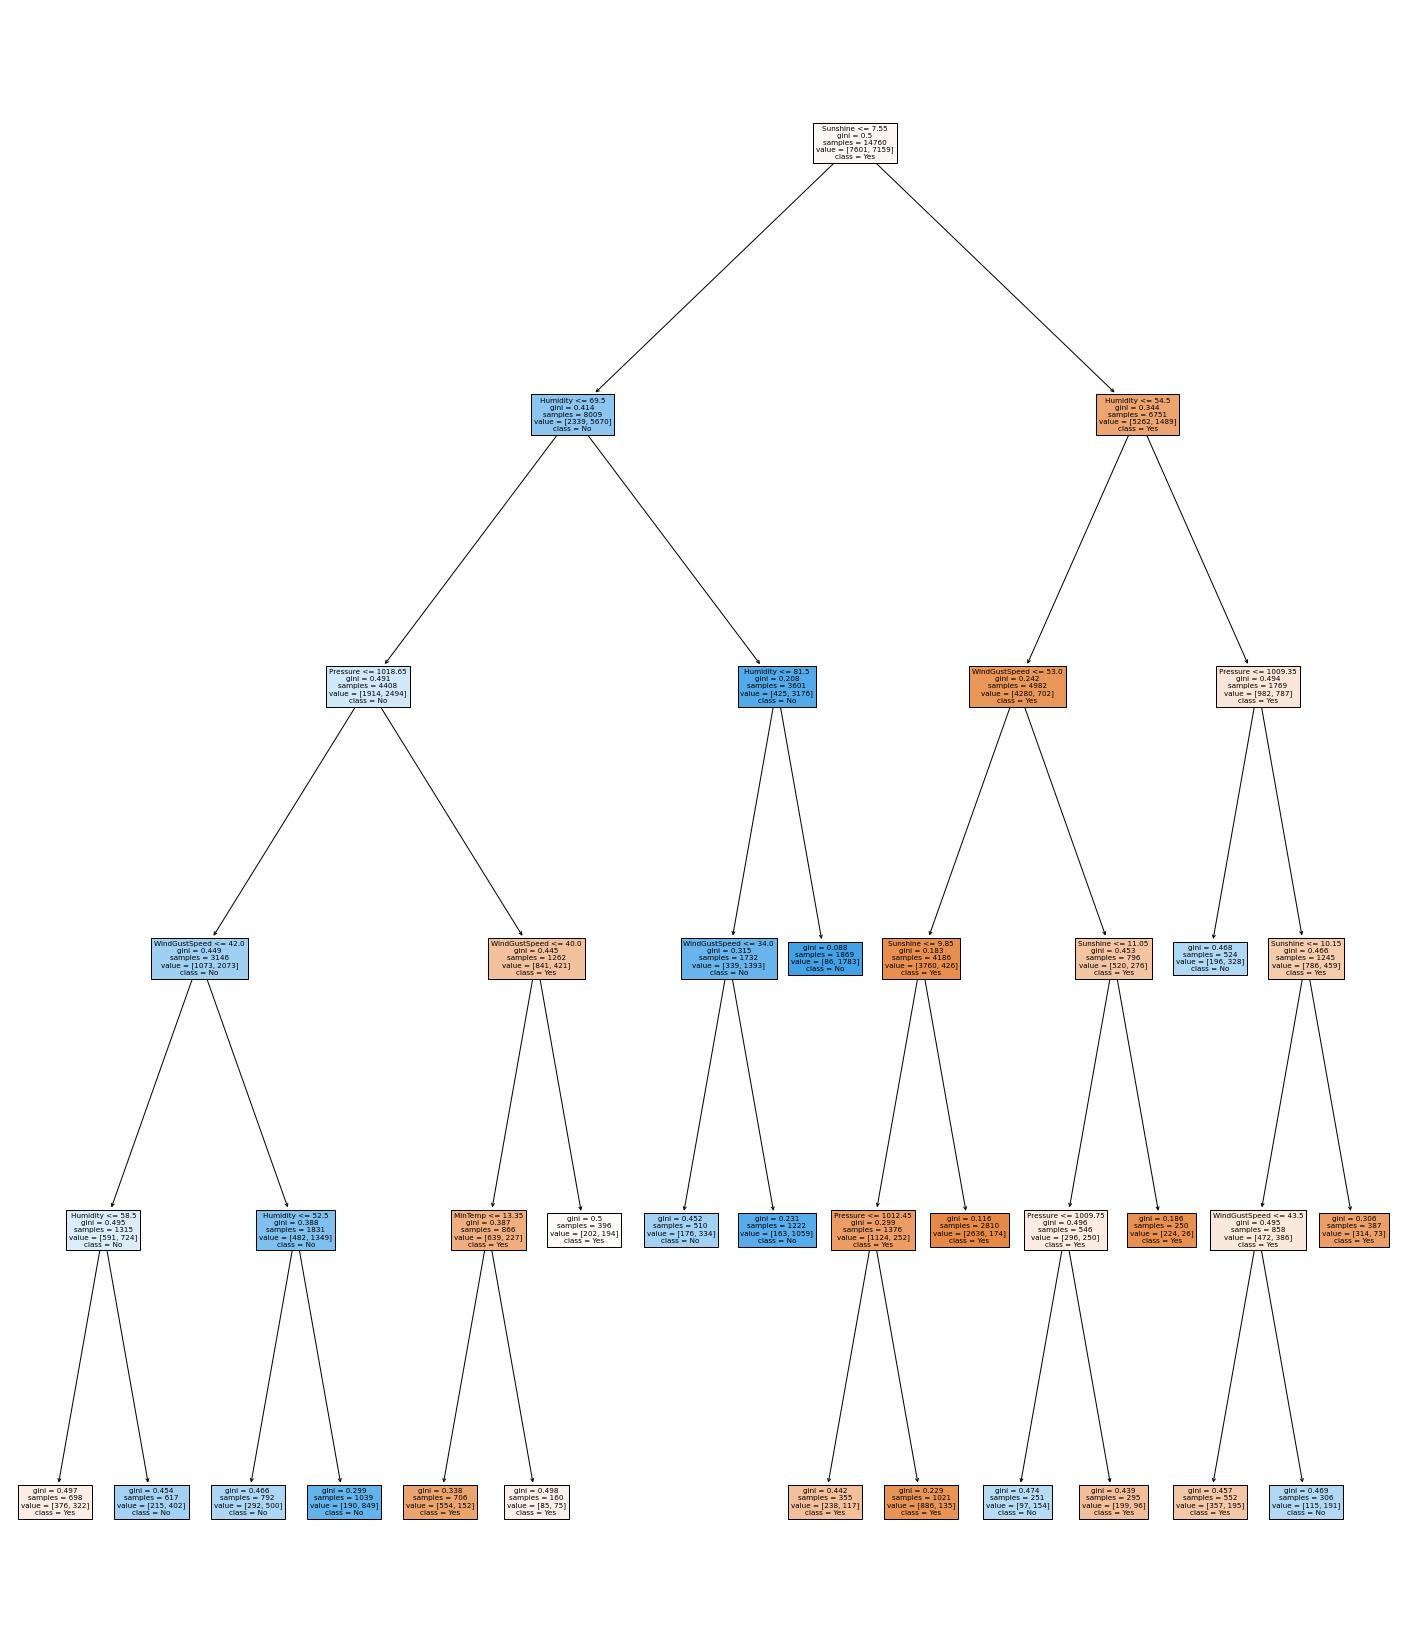

In [15]:
#decision tree visualization
from sklearn import tree
plt.figure(figsize = (25,30))
_ = tree.plot_tree(clf_best,
                  feature_names = DT_df_train.drop('RainTomorrow', axis = 1).columns,
                  class_names = ['Yes', 'No'],
                  filled = True)

# Prediction

Apply models to test data set and export it as a csvfile

In [59]:
#data normalization
WF_test_ = mmc.fit_transform(WF_test.drop('ID', axis = 1))
test_normalized = pd.DataFrame(WF_test_, columns = WF_test.drop('ID',axis =1).columns,
                               index = WF_test.drop('ID',axis =1).index)
#K-means output
kmeans_pred = kmeans_output.predict(test_normalized.drop('Temp', axis = 1))
#Decision tree output
tree_pred = clf_best.predict(WF_test.drop('ID', axis = 1))
#HAC out put
HAC_pred = HAC.fit_predict(test_normalized)
prediction_result = pd.DataFrame({'ID':WF_test['ID'],
                                  'K-means' : kmeans_pred,
                                  'HAC' : HAC_pred,
                                 'Decision Tree' : tree_pred})
result_group = {1:'No', 0:'Yes'}
prediction_result['K-means'].replace(result_group, inplace = True)
prediction_result['HAC'].replace(result_group, inplace = True)

In [69]:
prediction_result.to_csv('prediction result.csv')